# This is the notebook used to verify, directly with Baxter robot, the results from the readout testing

In [1]:
import vrep
import numpy
import time
import sys
import os
import subprocess
import save_load_file as slf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#
# Controls if the results are saved to a file
#

save2file = False

In [ ]:
# Location of the V-REP simulator main file:
vrep_location = "/Applications/V-REP_PRO_EDU_V3_2_2_Mac/vrep.app/Contents/MacOS/vrep"

# It's necessary to read the joint angles generated in the notebook BEE_Simulator_ArmControl_VREP_LSM_DATA-TESTER and send them to V-REP in order to generate the final Cartesian values.

In [3]:
def simulate_in_baxter(joint_angles):

    background_sim = True #Controls if subprocess is going to be used or an already running simulation.


    if background_sim:
        time_delays = 0.025
    else:
        time_delays = 0.075

    # To automate the process is necessary to avoid the firewall message by deactivating it!!!!
    if background_sim:
        p = subprocess.Popen([vrep_location, '-h', '-s', '-q', \
                              os.getcwd()+'/VREP_scenes/Baxter_IK_felt_pen_pick-and-place_testing_PARALLEL_IJCNN2016.ttt'])
    time.sleep(1.0)


    xyz_pos = []

    # Object names
    s0_name = 'Baxter_leftArm_joint1'
    s1_name = 'Baxter_leftArm_joint2'
    e1_name = 'Baxter_leftArm_joint4'
    w1_name = 'Baxter_leftArm_joint6'
    XY_reader = 'IK_Z_SLAVE'
    XY_pos = 'IK_XY_MASTER'
    Z_pos = 'IK_Z_MASTER'

    # print 'Program started'
    vrep.simxFinish(-1) # just in case, close all opened connections
    clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5)
    if clientID!=-1:
        # print 'Connected to remote API server'
        res,objs=vrep.simxGetObjects(clientID,vrep.sim_handle_all,vrep.simx_opmode_oneshot_wait) # gets ALL object handles
        if res==vrep.simx_return_ok:
            # print 'Number of objects in the scene: ',len(objs)


            res1,XYr=vrep.simxGetObjectHandle(clientID,XY_reader,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the XY master

            res2,s0=vrep.simxGetObjectHandle(clientID,s0_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the s0 joint
            res3,s1=vrep.simxGetObjectHandle(clientID,s1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the s1 joint
            res4,e1=vrep.simxGetObjectHandle(clientID,e1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the e1 joint
            res5,w1=vrep.simxGetObjectHandle(clientID,w1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the w1 joint

            if (res1*res2*res3*res4*res5)==vrep.simx_return_ok:
                # print "Ok, I'm in!"

                joint_list = [s0,s1,e1,w1]

                # print "Receiving the joint values"
                
                for ji in joint_angles:
                    #
                    # Receives the joint values from the neural network:
                    #
                    vrep.simxPauseCommunication(clientID,1);
                    vrep.simxSetJointPosition(clientID,joint_list[0],ji[0],vrep.simx_opmode_oneshot);
                    vrep.simxSetJointPosition(clientID,joint_list[1],ji[1],vrep.simx_opmode_oneshot);
                    vrep.simxSetJointPosition(clientID,joint_list[2],ji[2],vrep.simx_opmode_oneshot);
                    vrep.simxSetJointPosition(clientID,joint_list[3],ji[3],vrep.simx_opmode_oneshot);                
                    vrep.simxPauseCommunication(clientID,0);
                    # Above's 3 joints will be received and set on the V-REP side at the same time
                    time.sleep(time_delays)

                    # Reads and saves the current XY positions
                    res,pos = vrep.simxGetObjectPosition(clientID,XYr,-1,vrep.simx_opmode_oneshot_wait)
                    #time.sleep(time_delays)

                    if res!=0:
                        vrep.simxFinish(clientID)
                        print 'Remote API function call returned with error code - 2: ',res
                    else:
                        xyz_pos.append(pos)
            else:
                print 'Remote API function call returned with error code - 1: ',res
        else:
            print 'Remote API function call returned with error code - 0: ',res
    #     returncode=vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot_wait)
        vrep.simxFinish(clientID)
    else:
        print 'Failed connecting to remote API server'
    # print 'Program ended'

    # Terminates the process, in the case the connection above failed.
    if background_sim:
        p.terminate()
    time.sleep(0.5)

    # Saves the result of all the trials
    if save2file:
        numpy.save("./"+base_dir+"/"+sim_set+"/xyz_pos_all_trials_"+str(tji)+".npy",xyz_pos_all_trials)
    
    return numpy.array(xyz_pos)

In [4]:
sim_set = "circle" # basically is the name of the folder where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

In [6]:
%%time

simulation_type = "parallel"
# simulation_type = "serial"
# simulation_type = "true_serial"

lsm_i = "ALL"
# lsm_i = 0
trials_range = range(10)
# trials_range = [0] # used to simulate individually selected trials


for trial_number in trials_range:

    filename = "./"+base_dir+"/"+sim_set+"/joint_angles_mean_"+simulation_type+"_"+str(lsm_i)+"_"+str(trial_number)+".npy"
    joint_angles_mean = numpy.load(filename)

# filename = "./"+base_dir+"/"+sim_set+"/joint_angles_individual"+simulation_type+"_"+str(lsm_i)+"_"+str(trial_number)+".npy"
# joint_angles_individual = numpy.load(filename)

    xyz_pos = simulate_in_baxter(joint_angles_mean)
    filename = "./"+base_dir+"/"+sim_set+"/baxter_xyz_joint_angles_mean_"+simulation_type+"_"+str(lsm_i)+"_"+str(trial_number)+".npy"
    if save2file:
        numpy.save(filename,xyz_pos)

CPU times: user 4.29 s, sys: 5.93 s, total: 10.2 s
Wall time: 12min 47s


# Visualises the last trial

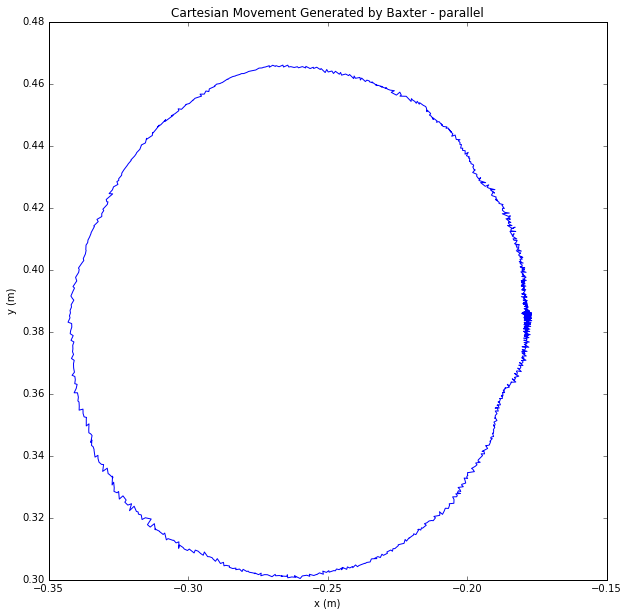

In [7]:
plt.figure(figsize =(10,10))
plt.plot(xyz_pos[:,0],xyz_pos[:,1])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Cartesian Movement Generated by Baxter - "+simulation_type)
plt.show()

# Loads the values from files:

./BaxterArm_VREP_simulation_data/circle/baxter_xyz_joint_angles_mean_parallel_ALL_0.npy


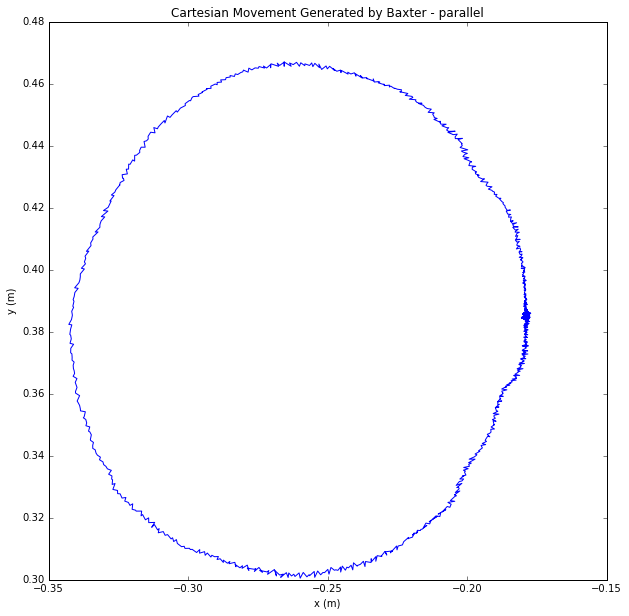

In [5]:
simulation_type = "parallel"
# simulation_type = "serial"
# simulation_type = "true_serial"

lsm_i = "ALL"
# lsm_i = 0
trial_number = 0


filename = "./"+base_dir+"/"+sim_set+"/baxter_xyz_joint_angles_mean_"+simulation_type+"_"+str(lsm_i)+"_"+str(trial_number)+".npy"
xyz_pos = numpy.load(filename)

print filename

plt.figure(figsize =(10,10))
plt.plot(xyz_pos[:,0],xyz_pos[:,1])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Cartesian Movement Generated by Baxter - "+simulation_type)
plt.show()
